In [32]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_community.document_loaders import ArxivLoader
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState
from langgraph.constants import Send
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_mistralai import ChatMistralAI
import os
from langchain_core.tools import tool
from pydantic import BaseModel, Field


In [33]:
prompt = "I am working on a project about generative molecular design. Can you pull up some relevant papers for me?"

In [ ]:
class ResponseFormatter(BaseModel):
    """Always use this tool to structure your response to the user."""
    nodes: List[(str, str)] = Field(description="(The answer to the user's question, ")

In [ ]:
import json
import requests

# 1. Load your workflow JSON file containing all possible nodes
with open("workflow_nodes.json", "r") as file:
    workflow_nodes = json.load(file)

# 2. Define your natural language query.
# (In a real application, you might get this from user input.)
natural_language_query = "Schedule a workflow that processes user data and generates a report, ensuring all data validation steps are performed."

# 3. Construct the prompt for the Mistral API.
# The prompt includes the list of available nodes (with prerequisites, tasks, etc.)
# and instructs the model to output a minimal schedule with justifications.
prompt = f"""
You are an orchestrator node in an agentic workflow.
Below is the JSON list of all available nodes. Each node includes its 'id', 'prerequisites', 'task', and if applicable, its 'return_value':
{json.dumps(workflow_nodes, indent=2)}

Given the following natural language query:
\"\"\"{natural_language_query}\"\"\"

Generate a schedule that visits the minimal number of nodes while ensuring that every prerequisite is satisfied.
For every node in your schedule, provide:
1. The node id and its position in the schedule.
2. A justification explaining why this node was selected.
3. A justification for why it is placed at that specific position in the schedule.

Return your answer as a JSON object representing the schedule.
"""

# 4. Prepare the API call to Mistral.
api_url = "https://api.mistral.ai/v1/chat/completions"
headers = {
    "Authorization": "Bearer YOUR_API_KEY",  # Replace with your actual API key
    "Content-Type": "application/json"
}

payload = {
    "model": "mistral-medium",  # or your preferred model
    "messages": [
        {"role": "system", "content": "You are a scheduling orchestrator for an agentic workflow."},
        {"role": "user", "content": prompt}
    ]
}

# 5. Make the API call
response = requests.post(api_url, headers=headers, json=payload)

# 6. Process and display the schedule response from Mistral
if response.status_code == 200:
    schedule_result = response.json()
    print("Schedule generated by Mistral:")
    print(json.dumps(schedule_result, indent=2))
else:
    print("Error:", response.status_code, response.text)


In [20]:
llm = ChatMistralAI(model="mistral-large-latest")

In [40]:
class SearchQuery(BaseModel):
    search_query: list[str] = Field(None, description="Output the least number of tasks that are necessary to complete the user's query in the format of a schedue")
    justification: list[str] = Field(
        None, description="Justification for each to-do item and why it is in its respective position in the list"
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("I want to do research on flash attention")

In [43]:
len(output.justification)

6

In [30]:
class SearchQuery(BaseModel):
    tool_name: str = Field(None, description="The tool chosen by the model")
    tool_args: dict = Field(None, description="The arguments to pass to the tool")
    justification: str = Field(None, description="Explain why this tool was selected")

@tool
def query_arxiv(arxiv_query: str) -> str:
    """Query Arxiv (https://arxiv.org/) and our corresponding vector database."""
    return f"Searching Arxiv for: {arxiv_query}"

@tool
def add(a: int, b: int) -> int:
    """Adds two numbers together."""
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divides two numbers."""
    return a / b


# Bind LLM with structured output

llm_with_tools = llm.bind_tools([query_arxiv, add, divide])

# Bind tools
llm_with_structure = llm_with_tools.with_structured_output(SearchQuery)

In [31]:
llm_with_tools.invoke("Multiply 3 and 2?")

AIMessage(content='The product of 3 and 2 is 6.', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 229, 'total_tokens': 241, 'completion_tokens': 12}, 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run-f55928a8-cea2-4a89-838e-cceb95f769c0-0', usage_metadata={'input_tokens': 229, 'output_tokens': 12, 'total_tokens': 241})

In [118]:
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant with helping deep research queries"
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""
    print(state["messages"])
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

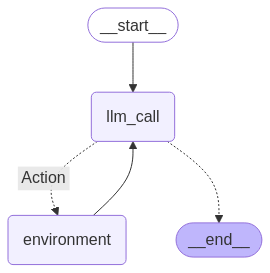

[HumanMessage(content='I am reading this paper, Restructuring Vector Quantization with the Rotation Trick. Can you help me answer some questions about it?', additional_kwargs={}, response_metadata={}, id='8fcb2270-3d57-4b3e-a883-9764e4a5224d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8z4sp2YDa', 'function': {'name': 'query_arxiv', 'arguments': '{"arxiv_query": "Restructuring Vector Quantization with the Rotation Trick"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 149, 'total_tokens': 187, 'completion_tokens': 38}, 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls'}, id='run-3d746fe1-5448-4244-bf88-f8e121857723-0', tool_calls=[{'name': 'query_arxiv', 'args': {'arxiv_query': 'Restructuring Vector Quantization with the Rotation Trick'}, 'id': '8z4sp2YDa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 38, 'total_tokens': 187})]
================================ Human Message ========================

In [120]:
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="I am reading this paper, Restructuring Vector Quantization with the Rotation Trick. Can you help me answer some questions about it?")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [55]:
docs = loader.load()

In [75]:
loader = ArxivLoader(
    query="reasoning",
    # load_max_docs=2,
    # load_all_available_meta=False
)

In [64]:
ai_msg.content

'Sure, here are five query phrases for Arxiv that should help you find papers using IGSO(3) generation for small molecules:\n\n1. **"IGSO(3) generation small molecules"**\n   - This query is straightforward and looks for papers that mention IGSO(3) generation and small molecules.\n\n2. **"IGSO(3) small molecule generation site:arxiv.org"**\n   - This query is similar to the first one, but it ensures that the search is restricted to Arxiv.\n\n3. **"IGSO(3) small molecule design"**\n   - This query uses an alternative term ("design") that might be used in some papers instead of "generation."\n\n4. **"IGSO(3) small molecule optimization"**\n   - This query uses another alternative term ("optimization") that might be relevant.\n\n5. **"IGSO(3) small molecule generation algorithm"**\n   - This query is more specific and looks for papers that discuss the generation algorithm for small molecules using IGSO(3).\n\nTo use these queries, simply enter them into the search bar on Arxiv (https://ar